In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

sns.set()

In [2]:
# load results for study bias holdout
n2v_result_df = pd.concat([
    pd.read_csv('../result/gene_classification_n2v.csv'),
    pd.read_csv('../result/gene_classification_n2vplus.csv'),
]).reset_index()
optim_idx_ary = n2v_result_df.groupby(['Network', 'Method', 'Task'])['Validation score'].agg('idxmax').values
optim_n2v_result_df = n2v_result_df.iloc[optim_idx_ary]

gnn_result_df = pd.read_csv('../result/gene_classification_gnn.csv')
result_df = pd.concat((optim_n2v_result_df, gnn_result_df))

In [3]:
pthresh = 0.05
pvt = [[pthresh, "*"], [1, ""]]

network_list = ['HumanBase-global', 'HumanBaseTop-global', 'STRING']
dataset_list = ['GOBP', 'DisGeNet']
n2v_method_list = ['Node2vec+', 'Node2vec']
method_list = ['GCN', 'GraphSAGE', 'Node2vec', 'Node2vec+']
method_name_dict = {'gcn': 'GCN', 'sage': 'GraphSAGE'}

color_dict = {
    "GCN": 'lightskyblue',
    "GraphSAGE": 'slateblue',
    "Node2vec+": 'orangered',
    "Node2vec": 'lightsalmon'
}

result_df['Method'].replace(method_name_dict, inplace=True)

In [4]:
def get_stat_annot(group, method_list):
    n_method = len(method_list)
    pval_list = []
    box_pair_list = []
    for dataset, subgroup in group.groupby('Dataset'):
        if dataset not in dataset_list:
            continue
        for idx1 in range(n_method - 1):
            for idx2 in range(idx1 + 1, n_method):
                method1, method2 = method_list[idx1], method_list[idx2]
                scores1 = subgroup[subgroup['Method'] == method1].sort_values('Task')['Testing score'].values
                scores2 = subgroup[subgroup['Method'] == method2].sort_values('Task')['Testing score'].values
                pval = stats.wilcoxon(scores1, scores2)[1]
                if pval < pthresh:
                    pval_list.append(pval)
                    box_pair_list.append(((dataset, method1), (dataset, method2)))

    return pval_list, box_pair_list

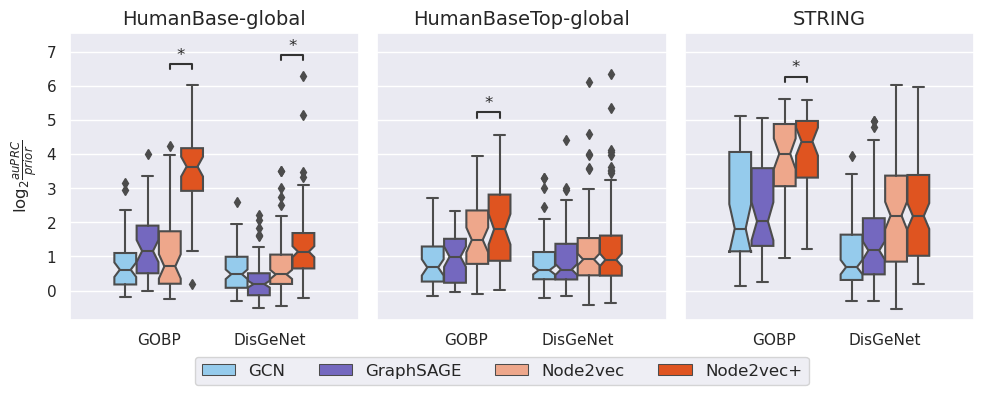

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey='row')

for network, group in result_df.groupby('Network'):
    network_idx = network_list.index(network)
    ax = axes[network_idx]

    sns.boxplot(data=group, order=dataset_list, x='Dataset',
                y='Testing score', palette=color_dict, hue='Method',
                hue_order=method_list, notch=True, ax=ax)

    pval_list, box_pair_list = get_stat_annot(group, n2v_method_list)
    if len(pval_list) > 0:
        add_stat_annotation(ax, data=group, x='Dataset', y='Testing score',
                            order=dataset_list, hue='Method', hue_order=method_list,
                            verbose=0, perform_stat_test=False, box_pairs=box_pair_list,
                            loc='inside', pvalue_thresholds=pvt, pvalues=pval_list)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.get_legend().remove()
    ax.set_title(network, fontsize=14)
axes[0].set_ylabel(r"$\log_2 \frac{auPRC}{prior}$")
plt.tight_layout()

plt.subplots_adjust(bottom=0.18)
axes[1].legend(bbox_to_anchor=(1.52, -0.1), ncol=4, fontsize=12)
# plt.savefig("fig_bio_nc_eval.png", dpi=300) # uncomment to save

plt.show()